In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef)

In [2]:
epochs1=mne.read_epochs('C:\\Users\\new user\\EEG data\\data\\Ex10_Suj1_Run1-epo.fif',preload=True)
epochs = epochs1[(epochs1.events[:,2] == 4) | (epochs1.events[:,2] == 5)]

Reading C:\Users\new user\EEG data\data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


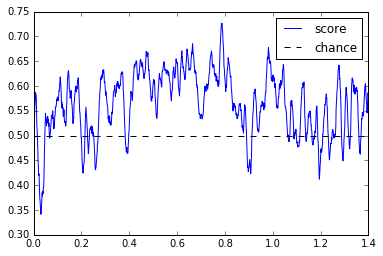

In [7]:
X = epochs.get_data()
y = epochs.events[:, 2]
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k='all'),  # select features for speed
                    LinearModel(LogisticRegression(C=1)))
time_decod = SlidingEstimator(clf, scoring='roc_auc')
# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
epochs=mne.read_epochs('C:\\Users\\new user\\EEG data\\data\\Ex10_Suj1_Run1-epo.fif',preload=True)

Reading C:\Users\new user\EEG data\data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


D:\New folder\envs\py27\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Classification accuracy: 0.239286 / Chance level: 0.746429


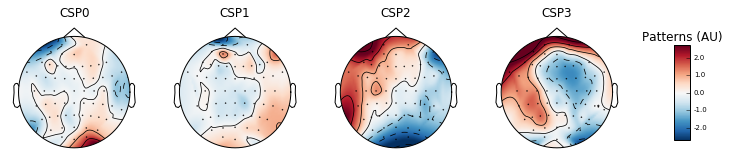

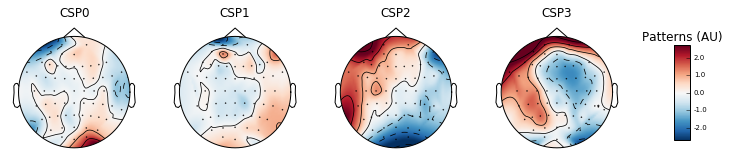

In [15]:
scores = []
labels = epochs.events[:, -1] - 2
epochs_train = epochs.copy().crop(tmin=1., tmax=1.4)
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)